# Dynamic Decoupling    



Quantum systems are highly sensitive to interactions with their environment. When a quantum bit (qubit) interacts with its surroundings, it can lose its quantum coherence—a process known as decoherence. Decoherence is a major challenge in quantum computing because it disrupts the information stored in qubits and causes computational errors.

For instance, If a qubit in a superposition state interacts with its environment, it can collapse into a classical state prematurely. Noisy interactions can also lead to random phase shifts, making the qubit’s state unpredictable. Dynamical Decoupling is designed to counteract these effects by using a sequence of control pulses that act to "cancel out" the interactions with the environment, thereby protecting the quantum information.

The idea behind Dynamical Decoupling is to apply a series of rapid, precisely-timed pulses to the quantum system. These pulses repeatedly rotate the state of the qubit in such a way that any interaction with the environment averages out over time, effectively isolating the qubit from its surroundings. Think of it as a "spin-echo" technique used in NMR (Nuclear Magnetic Resonance) or MRI (Magnetic Resonance Imaging), where spins are repeatedly flipped to counteract the effects of magnetic field inhomogeneities.

Here’s a simplified picture, imagine that a qubit interacts with its environment, causing it to drift out of alignment. By applying pulses (rotations) at specific times, we "flip" the state of the qubit, reversing the effect of the environment.
After enough flips, the interactions with the environment cancel out, leaving the qubit’s state largely unaffected.

Different sequences of pulses can be used to achieve Dynamical Decoupling. The effectiveness of each sequence depends on the type of noise (environmental interference) and the quantum system itself. Common sequences are Carr-Purcell-Meiboom-Gill(CPMG), XY-4, KDD and UDD 

Dynamical Decoupling is a key technique for preserving coherence in quantum systems. By applying carefully timed pulses or gates, DD cancels out environmental noise, effectively isolating the quantum system. This technique is especially valuable in the quest for robust quantum computers, as it helps extend qubit coherence times, making quantum computations more stable and reliable.

The ultimate goal of Dynamical Decoupling is to create a “noise-free” environment for qubits, allowing them to maintain their quantum state and perform calculations with minimal interference. It’s not a perfect solution for all types of noise, but it’s a powerful tool for mitigating decoherence and maintaining quantum information over time.

In [3]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

This code uses Qiskit to apply Dynamical Decoupling (DD) on a simple quantum circuit. It includes two types of DD sequences: a balanced X-X sequence on all qubits and a more advanced Uhrig Dynamical Decoupling (UDD) sequence on a specific qubit.

In [5]:
#  create circuit of 6 qubits

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.measure_all()

display(qc.draw('mpl'))


Define gate durations. Here, we define the duration of each gate in the circuit in units of "dt" (the hardware’s time unit). For example, a Hadamard gate on qubit 1 takes 50 dt, a CNOT between qubits 0 and 1 takes 900 dt, a CNOT between qubits 1 and 2 takes 600 dt. This is important because the dynamical decoupling sequences will be inserted between existing gates, and their placement depends on these durations.



In [19]:


durations = InstructionDurations(
    [("h", 0, 50), ("cx", [0, 1], 900), ("reset", None, 10),
     ("cx", [1, 2], 600),
     ("x", None, 50), ("measure", None, 1000)]
)

Applying a Balanced X-X Sequence on All Qubits. Define the DD Sequence: dd_sequence = [XGate(), XGate()] defines a simple sequence where two X gates are applied in succession.
PassManager requires ALAPScheduleAnalysis(durations). This pass schedules the circuit "As Late As Possible" (ALAP) within the defined durations. This helps in finding gaps in the circuit where DD pulses can be inserted. PadDynamicalDecoupling(durations, dd_sequence), this pass adds the defined dynamical decoupling sequence (X-X) to all qubits in the circuit in the gaps identified by the ALAP schedule. Run the PassManager, circ_dd = pm.run(circ) applies the defined passes to the circuit, adding the X-X DD sequence. Visualization, timeline_drawer(circ_dd) draws the timeline of the modified circuit, showing the inserted DD pulses.

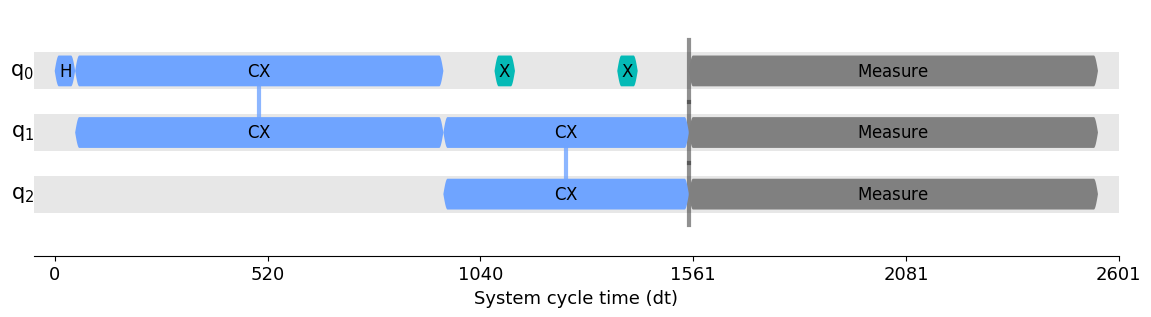

In [20]:
dynamicDecoupling_sequence = [XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dynamicDecoupling_sequence)])
qc_dynamicDecoupling = pm.run(qc)
timeline_drawer(qc_dynamicDecoupling)

The code now applies a more advanced Uhrig sequence on qubit 0, which uses unevenly spaced X pulses to improve protection against certain types of noise. n = 8 specifies the number of X pulses in the UDD sequence. dd_sequence = [XGate()] * n creates a list of X gates for the sequence. The uhrig_pulse_location function calculates the location of each pulse in the UDD sequence based on the Uhrig formula. Spacing is calculated based on uhrig_pulse_location(k). This list specifies the fractional positions within the interval where each pulse should be placed. Finally, spacing.append(1 - sum(spacing)) ensures that all spacings add up to 1 (or 100% of the interval).

In [21]:
n = 8
dd_sequence = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing = []
for k in range(n):
    spacing.append(uhrig_pulse_location(k) - sum(spacing))
spacing.append(1 - sum(spacing))


Applying the UDD Sequence to Qubit 1. The PadDynamicalDecoupling pass now applies the UDD sequence only on qubit 1 with the specified spacing. The modified circuit is created and visualized using timeline_drawer(circ_dd), showing the UDD pulses on qubit 1. 

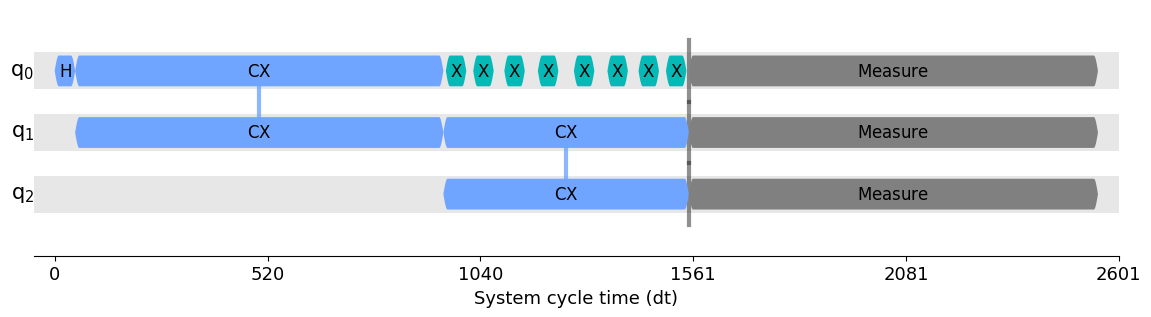

In [23]:
pm = PassManager(
    [
        ALAPScheduleAnalysis(durations),
        PadDynamicalDecoupling(durations, dd_sequence, qubits=[0], spacing=spacing),
    ]
)
qc_dynamicDecoupling = pm.run(qc)
timeline_drawer(qc_dynamicDecoupling)
